In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu'
import theano.tensor as T
import theano

sys.path.append(os.getcwd()+"/..")
import lasagne

from tasks import check
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from tqdm import tqdm

%matplotlib inline
from IPython.display import Image

import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
from helpers import salt_and_pepper
import lasagne
import pickle
from lasagne import layers

def load_gan_model(filename):
    import dcgan
    
    data = pickle.load(open(filename))
    gen = data['generator']
    discr = data['discriminator']
    return gen, discr

def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

def floatX(x):
    return x.astype(np.float32)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def sigmoid(x):
    return 1./(1. + np.exp(-x))

from tools.brushstroke.common import to_grid_of_images, disp_grid
from tools.brushstroke.common import load_model, get_bias, get_scale
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG

/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


## load model

In [2]:
from lightjob.cli import load_db
db = load_db()
s = db.get_job_by_summary('73da00fd56f4bba3a9cf4502d045ef70')['content']['model_summary']
filename = "../jobs/results/{}/model.pkl".format(s)
#filename ='../training/initial_models/model_E.pkl'

In [3]:
capsule, data, layers = load_model(filename)
c, w, h = layers['input'].shape[1:]

Loading data...


INFO:tasks:Loading data...


MemoryError: 

In [ ]:
for l in layers:
    print(l)

((100, 1, 28, 28), (100, 1, 28, 28))
0.0455195


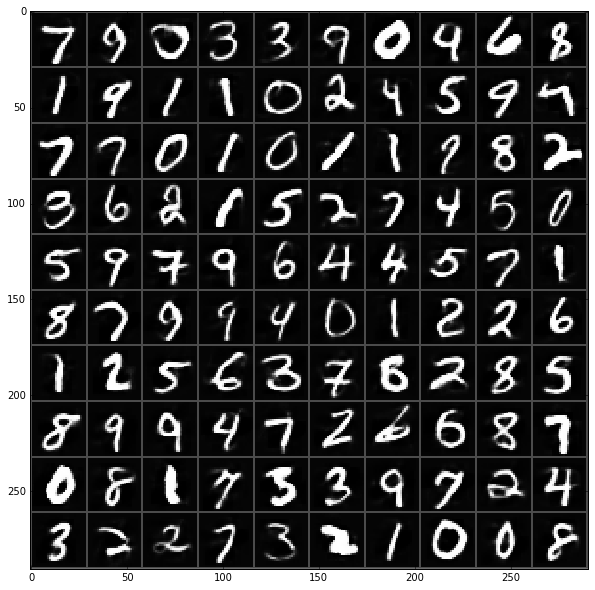

In [6]:
data.load()
X = data.X[0:100]
X = capsule.preprocess(X)
Xrec = capsule.reconstruct(X)
fig = plt.figure(figsize=(10,10))
plt.imshow(disp_grid(Xrec, border=1, bordercolor=(0.3,0.3,0.3)), interpolation='none')
print(X.shape, Xrec.shape)
print(np.abs(X-Xrec).mean())

## ProgramNeural network

In [ ]:
X_t = T.tensor4()
get_coords = theano.function([X_t], L.get_output(layers['coord_0_normalized'], X_t))
get_repr = theano.function([X_t], L.get_output(layers['repr_0_normalized'], X_t))

C = T.tensor3()
R = T.tensor3()
render = theano.function(
    [C, R],
    L.get_output(layers['output'], 
                 {layers['coord_0_normalized']: C, layers['repr_0_normalized']: R}, 
                 deterministic=True)
)

In [ ]:
feat_layers = [l for l in layers.keys() if 'normalized' in l]
get_feats = theano.function([X_t], [L.get_output(layers[l], X_t) for l in feat_layers])

In [ ]:
#get_coords_1 = theano.function([X_t], L.get_output(layers['coord_1_0_normalized'], X_t))
#get_rel_coords_1 = theano.function([X_t], L.get_output(layers['coord_5_0'], X_t))

In [ ]:
X = data.X[0:9]
X = capsule.preprocess(X)
coords = get_coords(X)
reprs = get_repr(X)

In [ ]:
reprs_ = reprs.copy()
coords_ = coords.copy()
coords_[:]=0.5
reprs_[:]=0
#coords_[:]=-10
#coords_[:,0]=0.5
#reprs_[:,0,0]=1

In [ ]:
Xrec = render(coords_, reprs_)
Xrec = Xrec
img = disp_grid(Xrec, border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png', width=400, height=400)

## Only come here To check vertebrate  convnets

In [ ]:
for l in layers.keys():
    print(l)

In [13]:
## print(layers)
#code_layers = ['hid5']
code_layers = ['conv3']
X_t = T.tensor4()
encode = theano.function(
    [X_t], 
    [L.get_output(layers[cc], X_t) for cc in code_layers]
)
code_t = [T.tensor4() for _ in code_layers]
decode = theano.function(
    code_t,
    L.get_output(layers['output'], {layers[name]: t for name, t in zip(code_layers, code_t)})
)

In [ ]:
X = data.X[0:100]
X=capsule.preprocess(X)

In [ ]:
C = encode(X)
Xrec = decode(*C)

In [ ]:
m = C[3][0][:, None, :, :]
fig = plt.figure(figsize=(10,10))
plt.imshow(disp_grid(m, border=1, bordercolor=(0.3, 0, 0)))

In [ ]:
C = list(encode(X))
cc = []#include these
for i in set(range(len(C))) - set(cc):
    C[i][:] = 0
C_zeros = [np.zeros_like(c) for c in C]
M = [0]#change these
"""
for _ in range(4):
    for i in M:
        F = C[i].shape[1]
        W = C[i].shape[2]
        H = C[i].shape[3]
        N = min(C[i].shape[0], F)
        C[i][np.arange(N), 
             np.arange(N), 
             np.random.randint(0, W, size=N), 
             np.random.randint(0, H, size=N)
             #0,
             #0,
        ] = 30
"""

for i in M:
    for n in range(N):
        F = C[i].shape[1]
        W = C[i].shape[2]
        H = C[i].shape[3]
        C[i][n, np.arange(F), np.random.randint(0, H, size=F), np.random.randint(0, W, size=F)] = 10

fig = plt.figure(figsize=(20, 20))
Xrec = decode(*C)
X_rec_zero = decode(*C_zeros)

res = Xrec# - X_rec_zero
recons = dispims_color(res.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1, bordercolor=(0.5,0.5,0.5))
plt.imshow(recons)

## viz features

input
conv1
(128, 5, 5, 3)


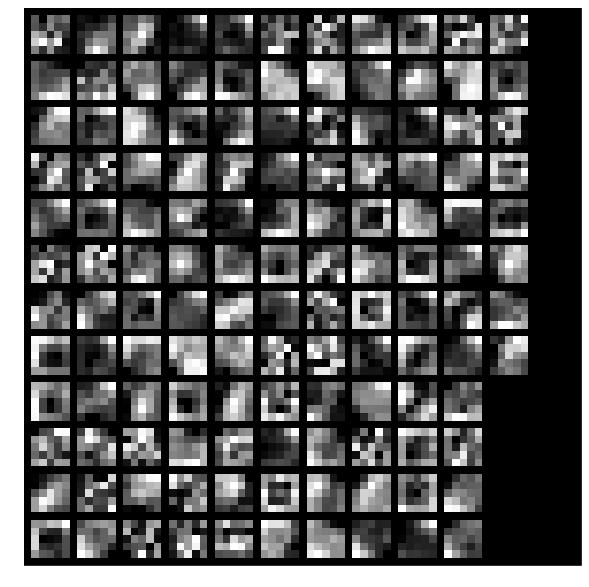

conv2
conv3
wta_spatial
wta_channel
unconv
(128, 13, 13, 3)


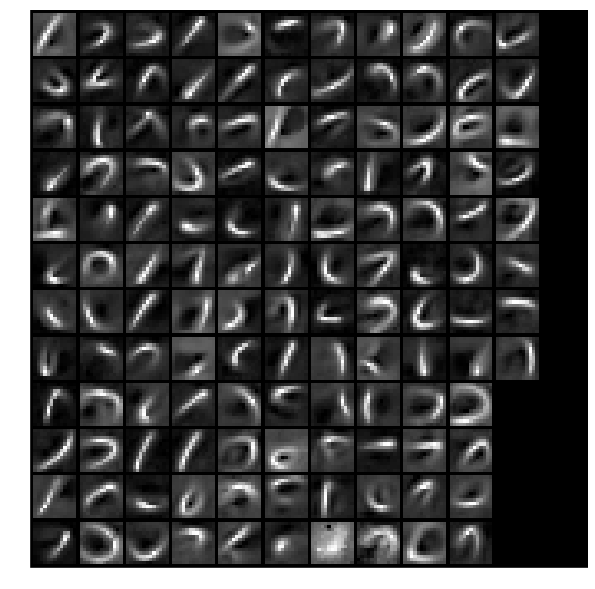

output


In [7]:
nbpixels = 28*28
c=1
for name, layer in layers.items():
    print(name)
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2 and (W.shape[0] == nbpixels or W.shape[1] == nbpixels):
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            W = W.reshape((W.shape[0], c, w, h))
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[1] in (1, 3):
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[0] in (1, 3):
            W = W.transpose((1, 2, 3, 0))
            W = W * np.ones((1, 1, 1, 3))
        else:
            #print(W.shape)
            continue
        fig = plt.figure(figsize=(10, 10))
        plt.axis('off')
        print(W.shape)
        img = dispims_color(W, border=1)
        plt.imshow(img, interpolation='none')
        plt.show()

## iterative refinement

In [8]:
seed = np.random.randint(1, 1000)
np.random.seed(42)
nb_iter = 100
N= 9
c=1
imgs = np.empty((N, nb_iter + 1, c, w, h))
imgs = imgs.astype(np.float32)
imgs[:, 0] = np.random.uniform(size=(N, c, w, h))
thresh = 'moving'
do_binarize = True
do_sample = False
whitepx_ratio = 0.13
bs = 100
for i in (range(1, nb_iter + 1)):
    sprev = imgs[:, i - 1]
    s = sprev.copy()
    for j in range(0, s.shape[0], bs):
        s[j:j+bs] = capsule.reconstruct(s[j:j+bs])
    #s = capsule.reconstruct(s)
    if do_sample:
        s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')
    if do_binarize:
        if thresh == 'moving':
            vals = s.flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        #print(thresh_)
        s = s > thresh_
    imgs[:, i] = s
    score = float(np.abs(s - sprev).mean())
    print(score)
    print(i)
    if score == 0:
        print('end')
        imgs = imgs[:, 0:i+1]
        break
samples = imgs.transpose((1, 0, 2, 3, 4))

0.470437437296
1
0.0481859408319
2
0.0277777779847
3
0.0192743763328
4
0.0189909301698
5
0.0121882082894
6
0.0144557822496
7
0.0113378688693
8
0.00821995455772
9
0.011054421775
10
0.00566893443465
11
0.00481859408319
12
0.00425170082599
13
0.00510204071179
14
0.00566893443465
15
0.00368480733596
16
0.00226757372729
17
0.0025510203559
18
0.00113378686365
19
0.00141723360866
20
0.00113378686365
21
0.000850340118632
22
0.000850340118632
23
0.000283446715912
24
0.00141723360866
25
0.00141723360866
26
0.000850340118632
27
0.000283446715912
28
0.000283446715912
29
0.0
30
end


/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


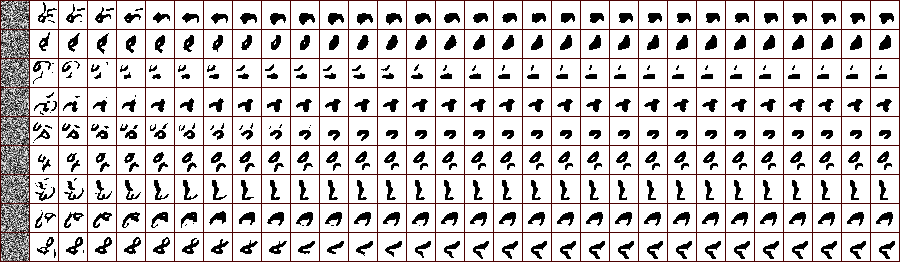

In [9]:
# sample samples and iterations
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
samples_ = 1 - samples_
img = dispims_color(samples_, shape=(sw, sh), border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png')

In [10]:
import os
from scripts.imgtovideo import imgs_to_video
from tools.brushstroke.common import embed_video
imgs = []
for s in samples:
    img = dispims_color((1-s).transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=2, bordercolor=(0.3, 0, 0))
    imgs.append(img)
if os.path.exists('out.mp4'):
    os.remove('out.mp4')
imgs_to_video(imgs, out='out.mp4', verbose=10, framerate=10, rate=10)
embed_video('out.mp4')

ffmpeg -framerate 10 -i img%08d.png -c:v libx264 -r 10 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/out.mp4


IOError: [Errno 2] No such file or directory: 'out.mp4'

## sne

In [16]:
mf = TSNE(n_components=2, perplexity=30)
#mf = PCA(n_components=2)
#X = data.train.X[0:14400 - len(samples[-1])]
X = data.train.X[0:100]
X = X.reshape((X.shape[0], c, h, w))
d = np.concatenate((X, samples[-1]), axis=0)
labels = np.array([1] * len(X) + [0] * len(samples[-1]))
hid, = encode(d)
hid = hid.reshape((hid.shape[0], -1))

print(hid.shape)
h2d = mf.fit_transform(hid)

(109, 32768)


109


/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


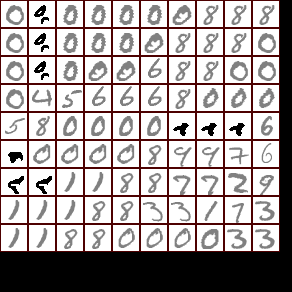

In [17]:
from sklearn.neighbors import NearestNeighbors
res = np.sqrt(len(h2d))
print(len(h2d))
x = np.linspace(0, 1, res)
y = np.linspace(0, 1, res)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
points = np.vstack((x, y)).T

knn = NearestNeighbors(n_neighbors=1)
h2d_ = (h2d - h2d.min(axis=0)) / (h2d.max(axis=0) - h2d.min(axis=0))
knn.fit(h2d_)
distances, indices = knn.kneighbors(points)
img = np.zeros((h*res, w*res, 3))
k = 0
for yy in np.arange(res):
    for xx in np.arange(res):
        if k >= len(indices)-1:
            continue
        s = d[indices[k]]
        im = s[0,0, :, :, np.newaxis]*np.ones((1,1,3))
        if labels[indices[k]]==1:
            im[:,:]*=0.5
        im[:, 0, :]=[0.7,1,1]
        im[:, -1, :]=[0.7,1,1]
        im[0, :, :]=[0.7,1,1]
        im[-1, :, :]=[0.7,1,1]
        im = 1-im
        try:
            img[yy*h:yy*h+h, xx*w:xx*w+w, :] = im
        except Exception:
            pass
        k += 1
imsave('imgs/out.png', img)
Image('imgs/out.png')